In [3]:
import pandas as pd

In [5]:
import datetime as dt 
from typing import Union, Dict, Set, List, TypedDict, Annotated
import pandas as pd
from langchain_core.tools import tool
import yfinance as yf
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volume import volume_weighted_average_price

@tool
def get_stock_prices(ticker: str) -> Union[Dict, str]:
    """Fetches historical stock price data and technical indicator for a given ticker."""
    try:
        data = yf.download(
            ticker,
            start=dt.datetime.now() - dt.timedelta(weeks=24*3),
            end=dt.datetime.now(),
            interval='1wk'
        )
        df= data.copy()
        data.reset_index(inplace=True)
        data.Date = data.Date.astype(str)
        
        indicators = {}
        
        rsi_series = RSIIndicator(df['Close'].squeeze(), window=14).rsi().iloc[-12:]
        indicators["RSI"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in rsi_series.dropna().to_dict().items()}
        
        sto_series = StochasticOscillator(
            df['High'].squeeze(), df['Low'].squeeze(), df['Close'].squeeze(), window=14).stoch().iloc[-12:]
        indicators["Stochastic_Oscillator"] = {
                    date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in sto_series.dropna().to_dict().items()}

        macd = MACD(df['Close'].squeeze())
        macd_series = macd.macd().iloc[-12:]
        indicators["MACD"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in macd_series.to_dict().items()}
        
        macd_signal_series = macd.macd_signal().iloc[-12:]
        indicators["MACD_Signal"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in macd_signal_series.to_dict().items()}
        
        vwap_series = volume_weighted_average_price(
            high=df['High'].squeeze(), low=df['Low'].squeeze(), close=df['Close'].squeeze(), 
            volume=df['Volume'].squeeze(),
        ).iloc[-12:]
        indicators["vwap"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in vwap_series.to_dict().items()}
        
        return {'stock_price': data.to_dict(orient='records'),
                'indicators': indicators}

    except Exception as e:
        return f"Error fetching price data: {str(e)}"

In [6]:
@tool
def get_financial_metrics(ticker: str) -> Union[Dict, str]:
    """Fetches key financial ratios for a given ticker."""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return {
            'pe_ratio': info.get('forwardPE'),
            'price_to_book': info.get('priceToBook'),
            'debt_to_equity': info.get('debtToEquity'),
            'profit_margins': info.get('profitMargins')
        }
    except Exception as e:
        return f"Error fetching ratios: {str(e)}"

In [8]:

@tool
def get_forecast(ticker: str) -> Union[Dict, str]:
    """Fetches key financial ratios for a given ticker."""
    # get the extracted data
    # perform forecast
    return #{'forecast1w':
           # 'forecast2w':
           # 'forecast1M':}

In [9]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]
    stock: str
    
graph_builder = StateGraph(State)

In [10]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:1b")

tools = [get_stock_prices, get_financial_metrics]
llm_with_tool = llm.bind_tools(tools)

In [11]:
FUNDAMENTAL_ANALYST_PROMPT = """
You are a fundamental analyst specializing in evaluating company (whose symbol is {company}) performance based on stock prices, technical indicators, and financial metrics. Your task is to provide a comprehensive summary of the fundamental analysis for a given stock.

You have access to the following tools:
1. **get_stock_prices**: Retrieves the latest stock price, historical price data and technical Indicators like RSI, MACD, Drawdown and VWAP.
2. **get_financial_metrics**: Retrieves key financial metrics, such as revenue, earnings per share (EPS), price-to-earnings ratio (P/E), and debt-to-equity ratio.

### Your Task:
1. **Input Stock Symbol**: Use the provided stock symbol to query the tools and gather the relevant information.
2. **Analyze Data**: Evaluate the results from the tools and identify potential resistance, key trends, strengths, or concerns.
3. **Provide Summary**: Write a concise, well-structured summary that highlights:
    - Recent stock price movements, trends and potential resistance.
    - Key insights from technical indicators (e.g., whether the stock is overbought or oversold).
    - Financial health and performance based on financial metrics.

### Constraints:
- Use only the data provided by user
- Avoid speculative language; focus on observable data and trends.

### Output Format:
Respond in the following format:
"stock": "<{company}>",
"price_analysis": "<Detailed analysis of stock price trends>",
"technical_analysis": "<Detailed time series Analysis from ALL technical indicators>",
"financial_analysis": "<Detailed analysis from financial metrics>",
"final Summary": "<Full Conclusion based on the above analyses>"
"Asked Question Answer": "<Answer based on the details and analysis above>
"""

def fundamental_analyst(state: State):
    messages = [
        SystemMessage(content=FUNDAMENTAL_ANALYST_PROMPT.format(company=state['stock'])),
    ]  + state['messages']
    return {
        'messages': llm_with_tool.invoke(messages)
    }

graph_builder.add_node('fundamental_analyst', fundamental_analyst)
graph_builder.add_edge(START, 'fundamental_analyst')

In [12]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(ToolNode(tools))
graph_builder.add_conditional_edges('fundamental_analyst', tools_condition)
graph_builder.add_edge('tools', 'fundamental_analyst')

graph = graph_builder.compile()

In [13]:
events = graph.stream({'messages':[('user', 'Should I buy this stock?')],
 'stock': 'TSLA'}, stream_mode='values', debug = True )
for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'messages': [('user', 'Should I buy this stock?')], 'stock': 'TSLA'}
[0:writes] Finished step 0 with writes to 2 channels:
- messages -> [('user', 'Should I buy this stock?')]
- stock -> 'TSLA'
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Should I buy this stock?', additional_kwargs={}, response_metadata={}, id='50f083ce-b774-4813-9e90-cbbab664c1d0')],
 'stock': 'TSLA'}
[1:tasks] Starting step 1 with 1 task:
- fundamental_analyst -> {'messages': [HumanMessage(content='Should I buy this stock?', additional_kwargs={}, response_metadata={}, id='50f083ce-b774-4813-9e90-cbbab664c1d0')],
 'stock': 'TSLA'}
================================ Human Message =================================

Should I buy this stock?
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> AIMessage(content='', additional_kwargs={}, response_metadata={'mode

[*********************100%***********************]  1 of 1 completed


[2:writes] Finished step 2 with writes to 1 channel:
- messages -> [ToolMessage(content="{'stock_price': [{('Date', ''): '2023-07-24', ('Adj Close', 'TSLA'): 266.44000244140625, ('Close', 'TSLA'): 266.44000244140625, ('High', 'TSLA'): 272.8999938964844, ('Low', 'TSLA'): 255.3000030517578, ('Open', 'TSLA'): 272.3800048828125, ('Volume', 'TSLA'): 423756800}, {('Date', ''): '2023-07-31', ('Adj Close', 'TSLA'): 253.86000061035156, ('Close', 'TSLA'): 253.86000061035156, ('High', 'TSLA'): 269.0799865722656, ('Low', 'TSLA'): 250.49000549316406, ('Open', 'TSLA'): 267.4800109863281, ('Volume', 'TSLA'): 466312800}, {('Date', ''): '2023-08-07', ('Adj Close', 'TSLA'): 242.64999389648438, ('Close', 'TSLA'): 242.64999389648438, ('High', 'TSLA'): 253.64999389648438, ('Low', 'TSLA'): 238.02000427246094, ('Open', 'TSLA'): 251.4499969482422, ('Volume', 'TSLA'): 517701600}, {('Date', ''): '2023-08-14', ('Adj Close', 'TSLA'): 215.49000549316406, ('Close', 'TSLA'): 215.49000549316406, ('High', 'TSLA'): 240

# Change the Graph Workflow

In [14]:
from langchain_core.messages import ToolMessage, AIMessage

In [15]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:1b")

In [16]:
import datetime as dt 
from typing import Union, Dict, Set, List, TypedDict, Annotated
import pandas as pd
from langchain_core.tools import tool
import yfinance as yf
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volume import volume_weighted_average_price

def get_stock_prices(state):
    """Fetches historical stock price data and technical indicator for a given ticker."""

    ticker = state['stock']
    try:
        data = yf.download(
            ticker,
            start=dt.datetime.now() - dt.timedelta(weeks=24*3),
            end=dt.datetime.now(),
            interval='1wk'
        )
        df= data.copy()
        data.reset_index(inplace=True)
        data.Date = data.Date.astype(str)
        
        indicators = {}
        
        rsi_series = RSIIndicator(df['Close'].squeeze(), window=14).rsi().iloc[-12:]
        indicators["RSI"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in rsi_series.dropna().to_dict().items()}
        
        sto_series = StochasticOscillator(
            df['High'].squeeze(), df['Low'].squeeze(), df['Close'].squeeze(), window=14).stoch().iloc[-12:]
        indicators["Stochastic_Oscillator"] = {
                    date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in sto_series.dropna().to_dict().items()}

        macd = MACD(df['Close'].squeeze())
        macd_series = macd.macd().iloc[-12:]
        indicators["MACD"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in macd_series.to_dict().items()}
        
        macd_signal_series = macd.macd_signal().iloc[-12:]
        indicators["MACD_Signal"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in macd_signal_series.to_dict().items()}
        
        vwap_series = volume_weighted_average_price(
            high=df['High'].squeeze(), low=df['Low'].squeeze(), close=df['Close'].squeeze(), 
            volume=df['Volume'].squeeze(),
        ).iloc[-12:]
        indicators["vwap"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in vwap_series.to_dict().items()}
        content = {'stock_price': data.to_dict(orient='records'),
                  'indicators': indicators}
        
        message = AIMessage(content = str(content))
        return {'messages': message,
                'extracted_data':content}

    except Exception as e:
        message = AIMessage(content = f"Error fetching price data: {str(e)}")
        return {'messages': message}


def get_financial_metrics(state) :
    """Fetches key financial ratios for a given ticker."""
    ticker = state['stock']
    
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        content = {
            'pe_ratio': info.get('forwardPE'),
            'price_to_book': info.get('priceToBook'),
            'debt_to_equity': info.get('debtToEquity'),
            'profit_margins': info.get('profitMargins')
        }
        message = AIMessage(content=str(content))
        return {'messages':message,
        }
    except Exception as e:
        message = AIMessage(content = f"Error fetching ratios: {str(e)}")
        return {'messages': message,
                'financial_metrics':content}

In [17]:
FUNDAMENTAL_ANALYST_PROMPT = """
You are a fundamental analyst specializing in evaluating company (whose symbol is {company}) performance based on stock prices, technical indicators, and financial metrics. Your task is to provide a comprehensive summary of the fundamental analysis for a given stock.
## Input
real time data = {extracted_data}
financial_metrics = {financial_metrics}

### Your Task:
1. **Analyze Data**: Evaluate the results from the tools and identify potential resistance, key trends, strengths, or concerns.
2. **Provide Summary**: Write a concise, well-structured summary that highlights:
    - Recent stock price movements, trends and potential resistance.
    - Key insights from technical indicators (e.g., whether the stock is overbought or oversold).
    - Financial health and performance based on financial metrics.

### Constraints:
- Use only the data provided by user
- Avoid speculative language; focus on observable data and trends.

### Output Format:
Respond in the following format:
"stock": "<{company}>",
"price_analysis": "<Detailed analysis of stock price trends>",
"technical_analysis": "<Detailed time series Analysis from ALL technical indicators>",
"financial_analysis": "<Detailed analysis from financial metrics>",
"final Summary": "<Full Conclusion based on the above analyses>"
"Asked Question Answer": "<Answer based on the details and analysis above>"

Ensure that your response is objective, concise, and actionable."""

def fundamental_analyst(state: State):
    messages = [
        SystemMessage(content=FUNDAMENTAL_ANALYST_PROMPT.format(company=state['stock'],extracted_data=state['extracted_data'],financial_metrics=state['financial_metrics'])),
    ]  + state['messages']
    return {
        'messages': llm.invoke(messages)
    }

In [18]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage
from typing import Dict

class State(TypedDict):
    messages: Annotated[list, add_messages]
    extracted_data : Dict
    financial_metrics : Dict
    stock: str
    
graph_builder = StateGraph(State)

In [19]:
graph_builder = StateGraph(State)
# Define Node
graph_builder.add_node('extract_data', get_stock_prices)
graph_builder.add_node('real_time_financial_metrics', get_financial_metrics)
graph_builder.add_node('fundamental_analyst', fundamental_analyst)

# Define Edge
graph_builder.add_edge(START, 'extract_data')
graph_builder.add_edge('extract_data', 'real_time_financial_metrics')
graph_builder.add_edge('real_time_financial_metrics', 'fundamental_analyst')
graph_builder.add_edge('fundamental_analyst', END)

graph = graph_builder.compile()


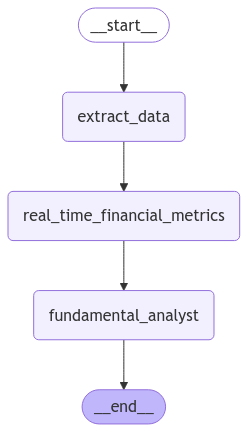

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

[*********************100%***********************]  1 of 1 completed

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'extracted_data': None,
 'financial_metrics': None,
 'messages': [('user', 'Should I buy this stock?')],
 'stock': 'TSLA'}
[0:writes] Finished step 0 with writes to 4 channels:
- messages -> [('user', 'Should I buy this stock?')]
- extracted_data -> None
- financial_metrics -> None
- stock -> 'TSLA'
[0:checkpoint] State at the end of step 0:
{'extracted_data': None,
 'financial_metrics': None,
 'messages': [HumanMessage(content='Should I buy this stock?', additional_kwargs={}, response_metadata={}, id='83f64fa2-ac0a-49b1-b662-eb1cdc51f174')],
 'stock': 'TSLA'}
[1:tasks] Starting step 1 with 1 task:
- extract_data -> {'extracted_data': None,
 'financial_metrics': None,
 'messages': [HumanMessage(content='Should I buy this stock?', additional_kwargs={}, response_metadata={}, id='83f64fa2-ac0a-49b1-b662-eb1cdc51f174')],
 'stock': 'TSLA'}
================================ Hum

[2:writes] Finished step 2 with writes to 1 channel:
- messages -> AIMessage(content="{'pe_ratio': 119.12169, 'price_to_book': 17.875357, 'debt_to_equity': 18.078, 'profit_margins': 0.13075}", additional_kwargs={}, response_metadata={})
[2:checkpoint] State at the end of step 2:
{'extracted_data': {'indicators': {'MACD': {...},
                                   'MACD_Signal': {...},
                                   'RSI': {...},
                                   'Stochastic_Oscillator': {...},
                                   'vwap': {...}},
                    'stock_price': [{...},
                                    {...},
                                    {...},
                                    {...},
                                    {...},
                                    {...},
                                    {...},
                                    {...},
                                    {...},
                                    {...},
                

KeyError: 'extracted_data'

In [24]:
state = {'messages':'should i buy this stock ?',
         'stock':'TSLA'}